# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

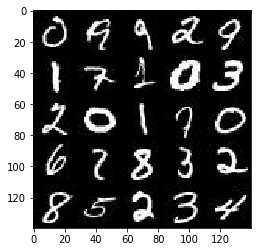

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

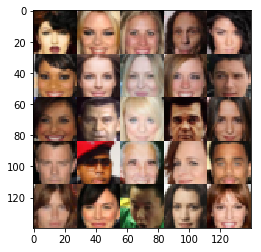

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32,[None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [33]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("discriminator",reuse=reuse):
        # 28*28*3
        cov1 = tf.layers.conv2d(images,64,3,strides=2, padding='same',kernel_initializer =tf.contrib.layers.xavier_initializer())
        cov1=tf.nn.dropout(cov1,0.8)
        # leak relu
        relu1 = tf.maximum(alpha * cov1, cov1)
        # 14*14*64
        
        cov2 = tf.layers.conv2d(relu1,128,3,strides=2, padding='same',kernel_initializer =tf.contrib.layers.xavier_initializer())
        cov2=tf.nn.dropout(cov2,0.9)
        bn2 = tf.layers.batch_normalization(cov2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7*7*128
        
        cov3 = tf.layers.conv2d(relu2,256,3,strides=2, padding='same',kernel_initializer =tf.contrib.layers.xavier_initializer())
        cov3=tf.nn.dropout(cov3,0.9)
        bn3 = tf.layers.batch_normalization(cov3,training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4*4*256
        
        flat = tf.reshape(relu3, (-1,np.prod(relu3.get_shape().as_list()[1:])))
        print("shape:"+str(np.prod(relu3.get_shape().as_list()[1:])))
        #flat = tf.reshape(relu3, (-1,4*4*256))
        flat=tf.nn.dropout(flat,0.9)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

shape:4096
shape:4096
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training,
    用来给batch_normal来标记的，它内部表示用的normal的均值是batch的还是global的
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1
    with tf.variable_scope("generator",reuse=not is_train):
        input1 = tf.layers.dense(z,4*4*512)
        input1 = tf.reshape(input1,(-1, 4, 4, 512))
        input1 = tf.layers.batch_normalization(input1, training=is_train)
        input1 = tf.maximum(alpha * input1, input1)
        # 4*4*512
        
        input2 = tf.layers.conv2d_transpose(input1,256, 4, strides=1, padding='valid',kernel_initializer =tf.contrib.layers.xavier_initializer())
        input2 = tf.layers.batch_normalization(input2, training=is_train)
        input2 = tf.maximum(alpha * input2, input2)
        # 7*7*256
        
        input3 = tf.layers.conv2d_transpose(input2,64, 3, strides=2, padding='same',kernel_initializer =tf.contrib.layers.xavier_initializer())
        input3 = tf.layers.batch_normalization(input3, training=is_train)
        input3 = tf.maximum(alpha * input3, input3)
        # 14*14*256
        
        input2 = tf.layers.conv2d_transpose(input3,out_channel_dim, 3, strides=2, padding='same',kernel_initializer =tf.contrib.layers.xavier_initializer())
        
        # 注意：这边输出的是-1--1
        out = tf.tanh(input2)
    
        print(out.get_shape().as_list())
        # 28*28*3
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

[None, 28, 28, 5]
[None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out= generator(input_z, out_channel_dim, is_train=True)
    
    # gan_mnist那一课的办法
    smooth=0.1
    d_out_real,d_logits_real =discriminator(input_real, reuse=False)
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_out_real) * (1 - smooth)))
    
    
    d_out_fake,d_logits_fake =discriminator(g_out, reuse=True)
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_out_fake)))
    
    d_loss=d_loss_real+d_loss_fake
    
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_out_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

[None, 28, 28, 4]
shape:4096
shape:4096
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    var_g=[var for var in tf.trainable_variables() if var.name.startswith("generator")]
    var_d=[var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt=tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=var_d)
        g_opt=tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=var_g)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width=data_shape[1]
    image_height=data_shape[2]
    image_channels=data_shape[-1]
    input_real, input_z, input_learning_rate =model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt=model_opt(d_loss, g_loss, input_learning_rate, beta1)
    batch_index =0
    losses=[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_index+=1
                # 注意这里要求输入-0.5*2--0.5*2
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # TODO: Train Model
                _ = sess.run(d_opt,feed_dict={input_real: batch_images, input_z: batch_z,input_learning_rate:learning_rate})
                
                _ = sess.run(g_opt,feed_dict={input_z: batch_z,input_learning_rate:learning_rate,input_real: batch_images})
                ## 
                if(batch_index%20==0):
                    train_loss_d=d_loss.eval({input_real: batch_images, input_z: batch_z,input_learning_rate:learning_rate})
                    train_loss_g=g_loss.eval({input_z: batch_z,input_learning_rate:learning_rate})
                    # Save losses to view after training 
                    losses.append((train_loss_d, train_loss_g))
                    print("Epoch {}/{}, Batch:{}...".format(epoch_i+1, epoch_count,batch_index),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if(batch_index%100==0):
#                     train_loss_d=d_loss.eval({input_real: batch_images, input_z: batch_z,input_learning_rate:learning_rate})
#                     train_loss_g=g_loss.eval({input_z: batch_z,input_learning_rate:learning_rate})
                    
#                     print("Epoch {}/{}, Batch:{}...".format(epoch_i+1, epoch_count,batch_index),
#                           "Discriminator Loss: {:.4f}...".format(train_loss_d),
#                           "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # see picture
                    show_generator_output(sess,25,input_z,image_channels,data_image_mode) 
                
    return losses


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

[None, 28, 28, 1]
shape:4096
shape:4096
Epoch 1/2, Batch:20... Discriminator Loss: 1.7158... Generator Loss: 6.4664
Epoch 1/2, Batch:40... Discriminator Loss: 1.4833... Generator Loss: 3.2854
Epoch 1/2, Batch:60... Discriminator Loss: 0.9134... Generator Loss: 2.5524
Epoch 1/2, Batch:80... Discriminator Loss: 1.2636... Generator Loss: 1.6997
Epoch 1/2, Batch:100... Discriminator Loss: 1.5251... Generator Loss: 1.5918
[None, 28, 28, 1]


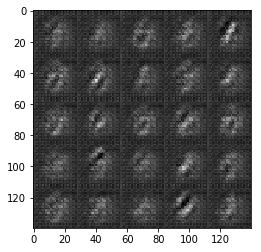

Epoch 1/2, Batch:120... Discriminator Loss: 1.2719... Generator Loss: 1.4019
Epoch 1/2, Batch:140... Discriminator Loss: 1.3898... Generator Loss: 1.8852
Epoch 1/2, Batch:160... Discriminator Loss: 1.4239... Generator Loss: 1.7358
Epoch 1/2, Batch:180... Discriminator Loss: 1.2886... Generator Loss: 2.0340
Epoch 1/2, Batch:200... Discriminator Loss: 1.3966... Generator Loss: 2.0723
[None, 28, 28, 1]


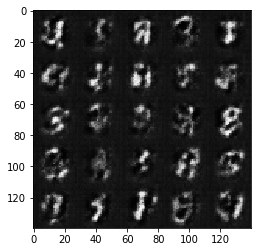

Epoch 1/2, Batch:220... Discriminator Loss: 1.1900... Generator Loss: 1.3929
Epoch 1/2, Batch:240... Discriminator Loss: 1.2649... Generator Loss: 1.7767
Epoch 1/2, Batch:260... Discriminator Loss: 1.3707... Generator Loss: 1.6282
Epoch 1/2, Batch:280... Discriminator Loss: 1.2192... Generator Loss: 1.4369
Epoch 1/2, Batch:300... Discriminator Loss: 1.1856... Generator Loss: 1.4588
[None, 28, 28, 1]


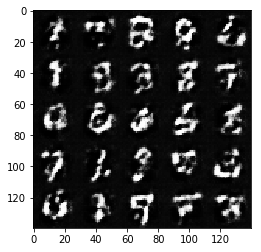

Epoch 1/2, Batch:320... Discriminator Loss: 1.2444... Generator Loss: 1.5805
Epoch 1/2, Batch:340... Discriminator Loss: 1.2023... Generator Loss: 1.4848
Epoch 1/2, Batch:360... Discriminator Loss: 1.4860... Generator Loss: 1.8671
Epoch 1/2, Batch:380... Discriminator Loss: 1.3172... Generator Loss: 1.6767
Epoch 1/2, Batch:400... Discriminator Loss: 1.2477... Generator Loss: 1.4145
[None, 28, 28, 1]


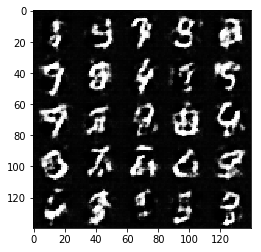

Epoch 1/2, Batch:420... Discriminator Loss: 1.2245... Generator Loss: 1.4174
Epoch 1/2, Batch:440... Discriminator Loss: 1.2896... Generator Loss: 1.2104
Epoch 1/2, Batch:460... Discriminator Loss: 1.3207... Generator Loss: 1.4303
Epoch 1/2, Batch:480... Discriminator Loss: 1.7235... Generator Loss: 1.9479
Epoch 1/2, Batch:500... Discriminator Loss: 1.2306... Generator Loss: 1.0059
[None, 28, 28, 1]


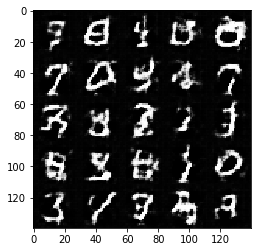

Epoch 1/2, Batch:520... Discriminator Loss: 1.2651... Generator Loss: 1.4466
Epoch 1/2, Batch:540... Discriminator Loss: 1.2867... Generator Loss: 1.3496
Epoch 1/2, Batch:560... Discriminator Loss: 1.4093... Generator Loss: 1.2291
Epoch 1/2, Batch:580... Discriminator Loss: 1.3555... Generator Loss: 1.3560
Epoch 1/2, Batch:600... Discriminator Loss: 1.4239... Generator Loss: 0.5020
[None, 28, 28, 1]


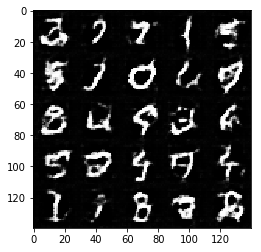

Epoch 1/2, Batch:620... Discriminator Loss: 1.2474... Generator Loss: 0.9861
Epoch 1/2, Batch:640... Discriminator Loss: 1.1909... Generator Loss: 0.8209
Epoch 1/2, Batch:660... Discriminator Loss: 1.1877... Generator Loss: 0.9611
Epoch 1/2, Batch:680... Discriminator Loss: 1.2811... Generator Loss: 0.8571
Epoch 1/2, Batch:700... Discriminator Loss: 1.2711... Generator Loss: 0.9244
[None, 28, 28, 1]


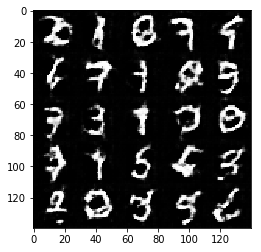

Epoch 1/2, Batch:720... Discriminator Loss: 1.5533... Generator Loss: 0.5264
Epoch 1/2, Batch:740... Discriminator Loss: 1.6599... Generator Loss: 0.3207
Epoch 1/2, Batch:760... Discriminator Loss: 1.3204... Generator Loss: 0.7402
Epoch 1/2, Batch:780... Discriminator Loss: 1.2697... Generator Loss: 1.2896
Epoch 1/2, Batch:800... Discriminator Loss: 1.2840... Generator Loss: 0.7206
[None, 28, 28, 1]


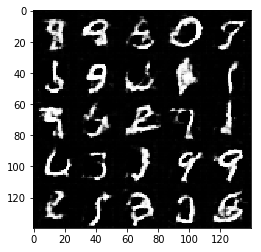

Epoch 1/2, Batch:820... Discriminator Loss: 1.1861... Generator Loss: 0.8703
Epoch 1/2, Batch:840... Discriminator Loss: 1.2238... Generator Loss: 0.8697
Epoch 1/2, Batch:860... Discriminator Loss: 1.3896... Generator Loss: 0.6925
Epoch 1/2, Batch:880... Discriminator Loss: 1.2633... Generator Loss: 1.2720
Epoch 1/2, Batch:900... Discriminator Loss: 1.3188... Generator Loss: 1.0257
[None, 28, 28, 1]


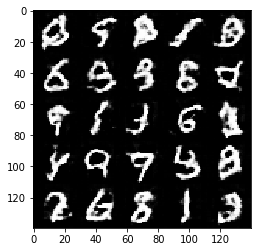

Epoch 1/2, Batch:920... Discriminator Loss: 1.2435... Generator Loss: 0.6465
Epoch 2/2, Batch:940... Discriminator Loss: 1.1089... Generator Loss: 0.8755
Epoch 2/2, Batch:960... Discriminator Loss: 1.1855... Generator Loss: 0.8136
Epoch 2/2, Batch:980... Discriminator Loss: 1.1970... Generator Loss: 1.2245
Epoch 2/2, Batch:1000... Discriminator Loss: 1.2488... Generator Loss: 1.1404
[None, 28, 28, 1]


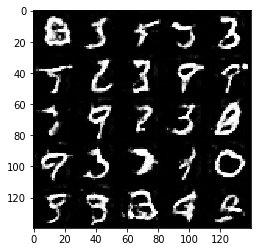

Epoch 2/2, Batch:1020... Discriminator Loss: 1.2303... Generator Loss: 0.8678
Epoch 2/2, Batch:1040... Discriminator Loss: 1.3961... Generator Loss: 0.6957
Epoch 2/2, Batch:1060... Discriminator Loss: 1.2159... Generator Loss: 0.8411
Epoch 2/2, Batch:1080... Discriminator Loss: 1.2390... Generator Loss: 1.6571
Epoch 2/2, Batch:1100... Discriminator Loss: 1.1912... Generator Loss: 1.5217
[None, 28, 28, 1]


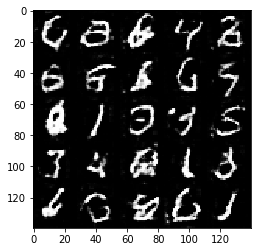

Epoch 2/2, Batch:1120... Discriminator Loss: 1.1584... Generator Loss: 1.0626
Epoch 2/2, Batch:1140... Discriminator Loss: 1.2007... Generator Loss: 1.1518
Epoch 2/2, Batch:1160... Discriminator Loss: 1.2316... Generator Loss: 1.3774
Epoch 2/2, Batch:1180... Discriminator Loss: 1.2137... Generator Loss: 0.9218
Epoch 2/2, Batch:1200... Discriminator Loss: 1.3139... Generator Loss: 0.5913
[None, 28, 28, 1]


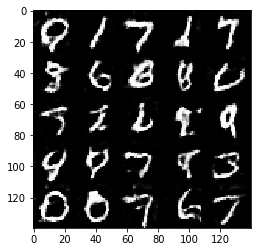

Epoch 2/2, Batch:1220... Discriminator Loss: 1.7378... Generator Loss: 2.1329
Epoch 2/2, Batch:1240... Discriminator Loss: 1.1725... Generator Loss: 1.1677
Epoch 2/2, Batch:1260... Discriminator Loss: 1.0970... Generator Loss: 1.4724
Epoch 2/2, Batch:1280... Discriminator Loss: 1.0669... Generator Loss: 1.1086
Epoch 2/2, Batch:1300... Discriminator Loss: 1.1107... Generator Loss: 1.0950
[None, 28, 28, 1]


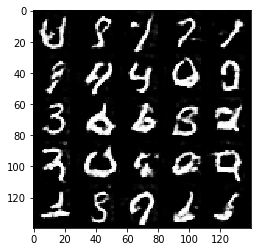

Epoch 2/2, Batch:1320... Discriminator Loss: 1.3470... Generator Loss: 0.6630
Epoch 2/2, Batch:1340... Discriminator Loss: 1.2903... Generator Loss: 1.2855
Epoch 2/2, Batch:1360... Discriminator Loss: 1.1761... Generator Loss: 0.8524
Epoch 2/2, Batch:1380... Discriminator Loss: 1.1506... Generator Loss: 1.5963
Epoch 2/2, Batch:1400... Discriminator Loss: 1.1496... Generator Loss: 0.8631
[None, 28, 28, 1]


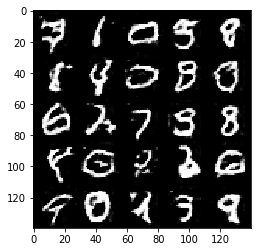

Epoch 2/2, Batch:1420... Discriminator Loss: 1.2504... Generator Loss: 1.4102
Epoch 2/2, Batch:1440... Discriminator Loss: 1.1889... Generator Loss: 1.2637
Epoch 2/2, Batch:1460... Discriminator Loss: 1.0626... Generator Loss: 1.2551
Epoch 2/2, Batch:1480... Discriminator Loss: 1.1546... Generator Loss: 0.8883
Epoch 2/2, Batch:1500... Discriminator Loss: 1.2281... Generator Loss: 0.6779
[None, 28, 28, 1]


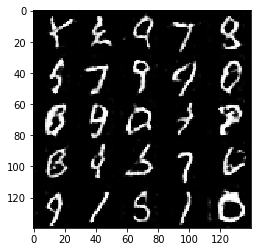

Epoch 2/2, Batch:1520... Discriminator Loss: 1.3027... Generator Loss: 0.6714
Epoch 2/2, Batch:1540... Discriminator Loss: 1.2029... Generator Loss: 0.6891
Epoch 2/2, Batch:1560... Discriminator Loss: 1.3709... Generator Loss: 0.5730
Epoch 2/2, Batch:1580... Discriminator Loss: 1.1536... Generator Loss: 1.0690
Epoch 2/2, Batch:1600... Discriminator Loss: 1.1791... Generator Loss: 0.8313
[None, 28, 28, 1]


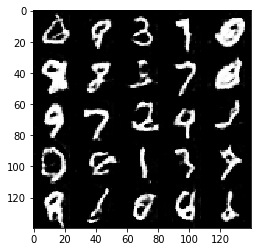

Epoch 2/2, Batch:1620... Discriminator Loss: 1.1398... Generator Loss: 0.8696
Epoch 2/2, Batch:1640... Discriminator Loss: 1.2728... Generator Loss: 0.6649
Epoch 2/2, Batch:1660... Discriminator Loss: 1.2847... Generator Loss: 0.6959
Epoch 2/2, Batch:1680... Discriminator Loss: 1.1451... Generator Loss: 1.4893
Epoch 2/2, Batch:1700... Discriminator Loss: 1.1066... Generator Loss: 0.9327
[None, 28, 28, 1]


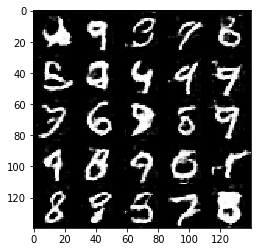

Epoch 2/2, Batch:1720... Discriminator Loss: 1.0844... Generator Loss: 1.5083
Epoch 2/2, Batch:1740... Discriminator Loss: 1.6287... Generator Loss: 0.3659
Epoch 2/2, Batch:1760... Discriminator Loss: 1.2157... Generator Loss: 0.9301
Epoch 2/2, Batch:1780... Discriminator Loss: 1.5167... Generator Loss: 1.7049
Epoch 2/2, Batch:1800... Discriminator Loss: 1.1198... Generator Loss: 1.1676
[None, 28, 28, 1]


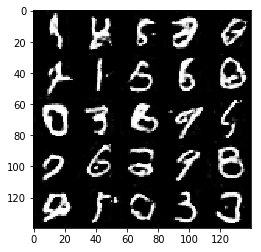

Epoch 2/2, Batch:1820... Discriminator Loss: 1.0541... Generator Loss: 1.2379
Epoch 2/2, Batch:1840... Discriminator Loss: 1.0332... Generator Loss: 0.9007
Epoch 2/2, Batch:1860... Discriminator Loss: 1.4063... Generator Loss: 1.8365


In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses=train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

[None, 28, 28, 3]
shape:4096
shape:4096
Epoch 1/1, Batch:20... Discriminator Loss: 1.6332... Generator Loss: 0.5400
Epoch 1/1, Batch:40... Discriminator Loss: 0.9790... Generator Loss: 1.2421
Epoch 1/1, Batch:60... Discriminator Loss: 0.9667... Generator Loss: 1.3761
Epoch 1/1, Batch:80... Discriminator Loss: 1.3115... Generator Loss: 0.6156
Epoch 1/1, Batch:100... Discriminator Loss: 1.1202... Generator Loss: 0.8423
[None, 28, 28, 3]


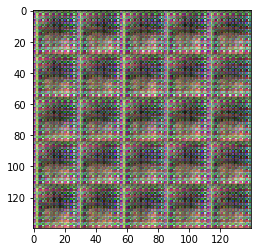

Epoch 1/1, Batch:120... Discriminator Loss: 1.0630... Generator Loss: 0.8679
Epoch 1/1, Batch:140... Discriminator Loss: 1.0841... Generator Loss: 0.9705
Epoch 1/1, Batch:160... Discriminator Loss: 1.0015... Generator Loss: 1.2061
Epoch 1/1, Batch:180... Discriminator Loss: 2.0855... Generator Loss: 7.4059
Epoch 1/1, Batch:200... Discriminator Loss: 0.8000... Generator Loss: 3.5358
[None, 28, 28, 3]


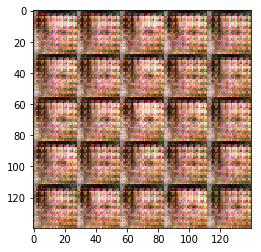

Epoch 1/1, Batch:220... Discriminator Loss: 0.6113... Generator Loss: 2.1104
Epoch 1/1, Batch:240... Discriminator Loss: 0.7532... Generator Loss: 1.9789
Epoch 1/1, Batch:260... Discriminator Loss: 1.2386... Generator Loss: 1.6711
Epoch 1/1, Batch:280... Discriminator Loss: 1.1922... Generator Loss: 1.2426
Epoch 1/1, Batch:300... Discriminator Loss: 1.3958... Generator Loss: 1.8792
[None, 28, 28, 3]


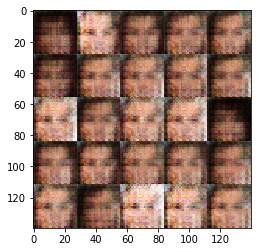

Epoch 1/1, Batch:320... Discriminator Loss: 1.3590... Generator Loss: 2.3757
Epoch 1/1, Batch:340... Discriminator Loss: 1.3748... Generator Loss: 2.4476
Epoch 1/1, Batch:360... Discriminator Loss: 1.1397... Generator Loss: 2.6019
Epoch 1/1, Batch:380... Discriminator Loss: 0.8669... Generator Loss: 2.2037
Epoch 1/1, Batch:400... Discriminator Loss: 1.1399... Generator Loss: 2.4855
[None, 28, 28, 3]


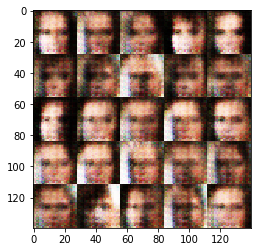

Epoch 1/1, Batch:420... Discriminator Loss: 1.1116... Generator Loss: 1.8874
Epoch 1/1, Batch:440... Discriminator Loss: 1.5673... Generator Loss: 0.5791
Epoch 1/1, Batch:460... Discriminator Loss: 1.4503... Generator Loss: 0.5142
Epoch 1/1, Batch:480... Discriminator Loss: 1.2477... Generator Loss: 0.7832
Epoch 1/1, Batch:500... Discriminator Loss: 1.3501... Generator Loss: 2.3536
[None, 28, 28, 3]


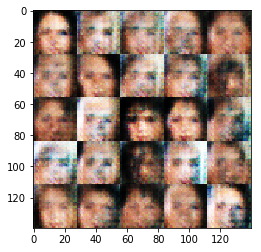

Epoch 1/1, Batch:520... Discriminator Loss: 0.9793... Generator Loss: 1.5936
Epoch 1/1, Batch:540... Discriminator Loss: 1.2530... Generator Loss: 1.1103
Epoch 1/1, Batch:560... Discriminator Loss: 1.1257... Generator Loss: 0.9119
Epoch 1/1, Batch:580... Discriminator Loss: 1.0403... Generator Loss: 1.0978
Epoch 1/1, Batch:600... Discriminator Loss: 1.1244... Generator Loss: 0.9279
[None, 28, 28, 3]


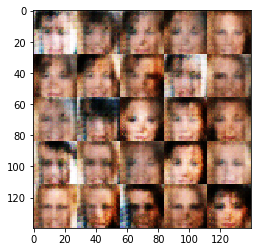

Epoch 1/1, Batch:620... Discriminator Loss: 1.1977... Generator Loss: 0.8391
Epoch 1/1, Batch:640... Discriminator Loss: 1.3436... Generator Loss: 0.7235
Epoch 1/1, Batch:660... Discriminator Loss: 1.3373... Generator Loss: 0.9591
Epoch 1/1, Batch:680... Discriminator Loss: 1.1318... Generator Loss: 0.9350
Epoch 1/1, Batch:700... Discriminator Loss: 1.4016... Generator Loss: 0.9128
[None, 28, 28, 3]


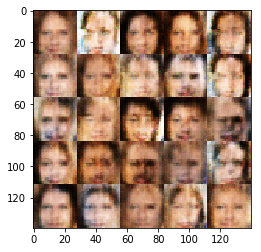

Epoch 1/1, Batch:720... Discriminator Loss: 1.3628... Generator Loss: 0.6091
Epoch 1/1, Batch:740... Discriminator Loss: 1.3519... Generator Loss: 0.8011
Epoch 1/1, Batch:760... Discriminator Loss: 1.2907... Generator Loss: 0.7365
Epoch 1/1, Batch:780... Discriminator Loss: 1.6482... Generator Loss: 0.4593
Epoch 1/1, Batch:800... Discriminator Loss: 1.4140... Generator Loss: 0.6698
[None, 28, 28, 3]


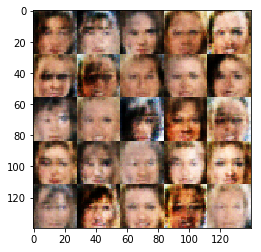

Epoch 1/1, Batch:820... Discriminator Loss: 1.2569... Generator Loss: 1.1004
Epoch 1/1, Batch:840... Discriminator Loss: 1.3823... Generator Loss: 0.7346
Epoch 1/1, Batch:860... Discriminator Loss: 1.3870... Generator Loss: 0.7803
Epoch 1/1, Batch:880... Discriminator Loss: 1.2630... Generator Loss: 0.9003
Epoch 1/1, Batch:900... Discriminator Loss: 1.2331... Generator Loss: 0.9875
[None, 28, 28, 3]


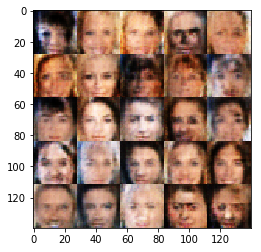

Epoch 1/1, Batch:920... Discriminator Loss: 1.4264... Generator Loss: 1.2395
Epoch 1/1, Batch:940... Discriminator Loss: 1.1893... Generator Loss: 1.0669
Epoch 1/1, Batch:960... Discriminator Loss: 1.5189... Generator Loss: 1.1739
Epoch 1/1, Batch:980... Discriminator Loss: 1.3854... Generator Loss: 1.2319
Epoch 1/1, Batch:1000... Discriminator Loss: 1.1871... Generator Loss: 0.8031
[None, 28, 28, 3]


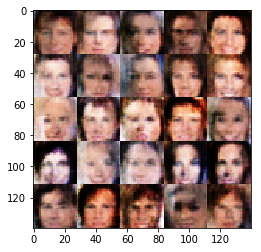

Epoch 1/1, Batch:1020... Discriminator Loss: 1.2930... Generator Loss: 0.8194
Epoch 1/1, Batch:1040... Discriminator Loss: 1.2987... Generator Loss: 0.8942
Epoch 1/1, Batch:1060... Discriminator Loss: 1.3036... Generator Loss: 0.8959
Epoch 1/1, Batch:1080... Discriminator Loss: 1.4246... Generator Loss: 1.2926
Epoch 1/1, Batch:1100... Discriminator Loss: 1.3323... Generator Loss: 1.0496
[None, 28, 28, 3]


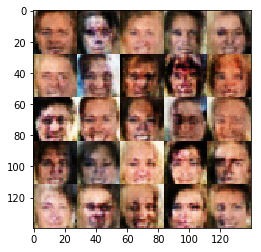

Epoch 1/1, Batch:1120... Discriminator Loss: 1.4792... Generator Loss: 0.5078
Epoch 1/1, Batch:1140... Discriminator Loss: 1.2709... Generator Loss: 0.7121
Epoch 1/1, Batch:1160... Discriminator Loss: 1.5215... Generator Loss: 0.6053
Epoch 1/1, Batch:1180... Discriminator Loss: 1.3624... Generator Loss: 0.6443
Epoch 1/1, Batch:1200... Discriminator Loss: 1.2382... Generator Loss: 1.1894
[None, 28, 28, 3]


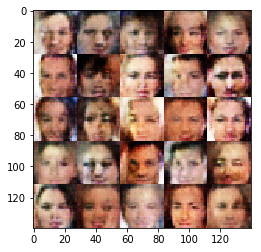

Epoch 1/1, Batch:1220... Discriminator Loss: 1.6952... Generator Loss: 1.6254
Epoch 1/1, Batch:1240... Discriminator Loss: 1.2722... Generator Loss: 0.9761
Epoch 1/1, Batch:1260... Discriminator Loss: 1.2641... Generator Loss: 0.8088
Epoch 1/1, Batch:1280... Discriminator Loss: 1.4333... Generator Loss: 0.5606
Epoch 1/1, Batch:1300... Discriminator Loss: 1.2847... Generator Loss: 0.5984
[None, 28, 28, 3]


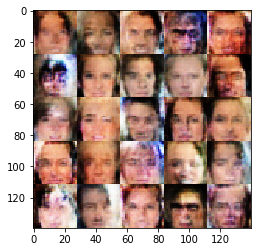

Epoch 1/1, Batch:1320... Discriminator Loss: 1.3425... Generator Loss: 0.6431
Epoch 1/1, Batch:1340... Discriminator Loss: 1.5229... Generator Loss: 0.5328
Epoch 1/1, Batch:1360... Discriminator Loss: 1.2477... Generator Loss: 0.7336
Epoch 1/1, Batch:1380... Discriminator Loss: 1.5878... Generator Loss: 0.4721
Epoch 1/1, Batch:1400... Discriminator Loss: 1.3027... Generator Loss: 0.7922
[None, 28, 28, 3]


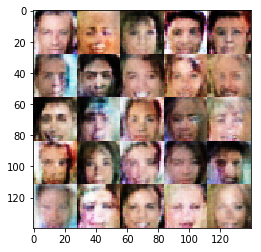

Epoch 1/1, Batch:1420... Discriminator Loss: 1.2279... Generator Loss: 1.0099
Epoch 1/1, Batch:1440... Discriminator Loss: 1.3118... Generator Loss: 0.8633
Epoch 1/1, Batch:1460... Discriminator Loss: 1.0808... Generator Loss: 1.1844
Epoch 1/1, Batch:1480... Discriminator Loss: 1.2787... Generator Loss: 0.6455
Epoch 1/1, Batch:1500... Discriminator Loss: 1.6577... Generator Loss: 0.3513
[None, 28, 28, 3]


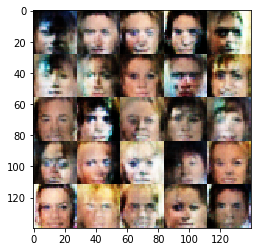

Epoch 1/1, Batch:1520... Discriminator Loss: 1.3259... Generator Loss: 1.2810
Epoch 1/1, Batch:1540... Discriminator Loss: 1.1665... Generator Loss: 1.1905
Epoch 1/1, Batch:1560... Discriminator Loss: 1.3303... Generator Loss: 1.1826
Epoch 1/1, Batch:1580... Discriminator Loss: 1.4234... Generator Loss: 0.5917
Epoch 1/1, Batch:1600... Discriminator Loss: 1.7736... Generator Loss: 1.7054
[None, 28, 28, 3]


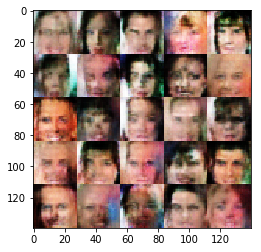

Epoch 1/1, Batch:1620... Discriminator Loss: 1.3095... Generator Loss: 0.5519
Epoch 1/1, Batch:1640... Discriminator Loss: 1.8568... Generator Loss: 1.7618
Epoch 1/1, Batch:1660... Discriminator Loss: 1.2596... Generator Loss: 0.8555
Epoch 1/1, Batch:1680... Discriminator Loss: 1.2788... Generator Loss: 0.8727
Epoch 1/1, Batch:1700... Discriminator Loss: 1.3236... Generator Loss: 0.6907
[None, 28, 28, 3]


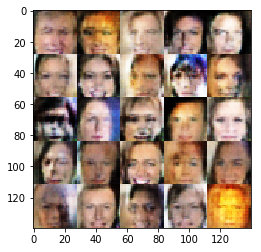

Epoch 1/1, Batch:1720... Discriminator Loss: 1.5073... Generator Loss: 0.5072
Epoch 1/1, Batch:1740... Discriminator Loss: 1.4128... Generator Loss: 1.3079
Epoch 1/1, Batch:1760... Discriminator Loss: 1.1994... Generator Loss: 0.9589
Epoch 1/1, Batch:1780... Discriminator Loss: 1.7399... Generator Loss: 0.3775
Epoch 1/1, Batch:1800... Discriminator Loss: 1.6029... Generator Loss: 0.4022
[None, 28, 28, 3]


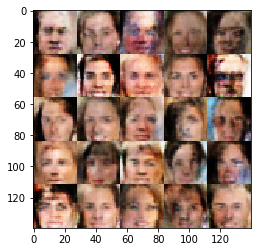

Epoch 1/1, Batch:1820... Discriminator Loss: 0.9433... Generator Loss: 1.3773
Epoch 1/1, Batch:1840... Discriminator Loss: 1.4442... Generator Loss: 0.6023
Epoch 1/1, Batch:1860... Discriminator Loss: 1.6686... Generator Loss: 0.4758
Epoch 1/1, Batch:1880... Discriminator Loss: 1.3476... Generator Loss: 0.7051
Epoch 1/1, Batch:1900... Discriminator Loss: 1.4189... Generator Loss: 0.6253
[None, 28, 28, 3]


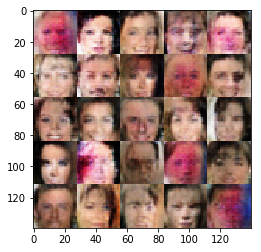

Epoch 1/1, Batch:1920... Discriminator Loss: 1.5445... Generator Loss: 0.4887
Epoch 1/1, Batch:1940... Discriminator Loss: 1.9560... Generator Loss: 2.2151
Epoch 1/1, Batch:1960... Discriminator Loss: 1.3485... Generator Loss: 0.5501
Epoch 1/1, Batch:1980... Discriminator Loss: 1.2510... Generator Loss: 1.0580
Epoch 1/1, Batch:2000... Discriminator Loss: 1.2971... Generator Loss: 0.7395
[None, 28, 28, 3]


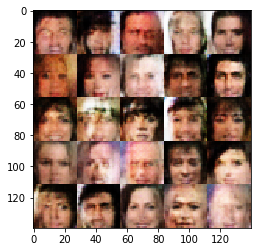

Epoch 1/1, Batch:2020... Discriminator Loss: 1.0185... Generator Loss: 1.2918
Epoch 1/1, Batch:2040... Discriminator Loss: 1.3244... Generator Loss: 1.2005
Epoch 1/1, Batch:2060... Discriminator Loss: 1.2707... Generator Loss: 0.7399
Epoch 1/1, Batch:2080... Discriminator Loss: 1.1668... Generator Loss: 1.0991
Epoch 1/1, Batch:2100... Discriminator Loss: 1.3015... Generator Loss: 0.8440
[None, 28, 28, 3]


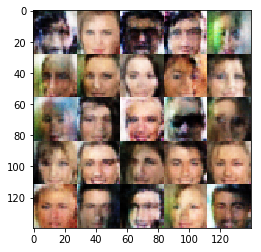

Epoch 1/1, Batch:2120... Discriminator Loss: 1.2452... Generator Loss: 0.9253
Epoch 1/1, Batch:2140... Discriminator Loss: 1.0722... Generator Loss: 1.1297
Epoch 1/1, Batch:2160... Discriminator Loss: 1.0966... Generator Loss: 0.8853
Epoch 1/1, Batch:2180... Discriminator Loss: 1.6252... Generator Loss: 0.4128
Epoch 1/1, Batch:2200... Discriminator Loss: 1.5452... Generator Loss: 1.4016
[None, 28, 28, 3]


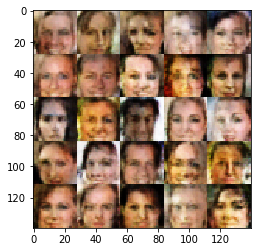

Epoch 1/1, Batch:2220... Discriminator Loss: 1.1509... Generator Loss: 1.0694
Epoch 1/1, Batch:2240... Discriminator Loss: 1.2674... Generator Loss: 0.6736
Epoch 1/1, Batch:2260... Discriminator Loss: 1.5530... Generator Loss: 1.2222
Epoch 1/1, Batch:2280... Discriminator Loss: 1.3696... Generator Loss: 0.6925
Epoch 1/1, Batch:2300... Discriminator Loss: 1.5319... Generator Loss: 0.4499
[None, 28, 28, 3]


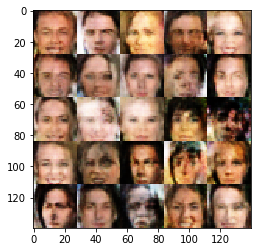

Epoch 1/1, Batch:2320... Discriminator Loss: 1.4445... Generator Loss: 1.2544
Epoch 1/1, Batch:2340... Discriminator Loss: 1.2337... Generator Loss: 0.8292
Epoch 1/1, Batch:2360... Discriminator Loss: 1.2533... Generator Loss: 1.0544
Epoch 1/1, Batch:2380... Discriminator Loss: 1.6245... Generator Loss: 1.1807
Epoch 1/1, Batch:2400... Discriminator Loss: 1.4238... Generator Loss: 0.5541
[None, 28, 28, 3]


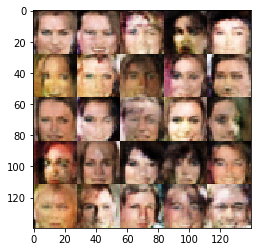

Epoch 1/1, Batch:2420... Discriminator Loss: 1.3394... Generator Loss: 0.6401
Epoch 1/1, Batch:2440... Discriminator Loss: 1.2971... Generator Loss: 0.6093
Epoch 1/1, Batch:2460... Discriminator Loss: 1.2531... Generator Loss: 0.8885
Epoch 1/1, Batch:2480... Discriminator Loss: 1.3864... Generator Loss: 1.0268
Epoch 1/1, Batch:2500... Discriminator Loss: 1.3207... Generator Loss: 0.7454
[None, 28, 28, 3]


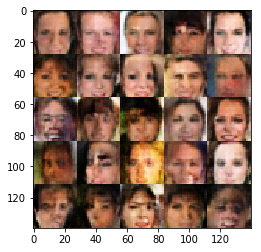

Epoch 1/1, Batch:2520... Discriminator Loss: 1.3828... Generator Loss: 0.6212
Epoch 1/1, Batch:2540... Discriminator Loss: 1.2555... Generator Loss: 1.1583
Epoch 1/1, Batch:2560... Discriminator Loss: 1.2466... Generator Loss: 1.0105
Epoch 1/1, Batch:2580... Discriminator Loss: 1.3281... Generator Loss: 1.1575
Epoch 1/1, Batch:2600... Discriminator Loss: 1.2109... Generator Loss: 1.0773
[None, 28, 28, 3]


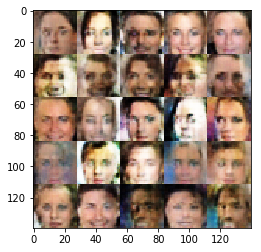

Epoch 1/1, Batch:2620... Discriminator Loss: 1.4938... Generator Loss: 0.7428
Epoch 1/1, Batch:2640... Discriminator Loss: 1.2525... Generator Loss: 0.8046
Epoch 1/1, Batch:2660... Discriminator Loss: 1.2191... Generator Loss: 0.7149
Epoch 1/1, Batch:2680... Discriminator Loss: 1.0837... Generator Loss: 1.0258
Epoch 1/1, Batch:2700... Discriminator Loss: 1.6026... Generator Loss: 0.5262
[None, 28, 28, 3]


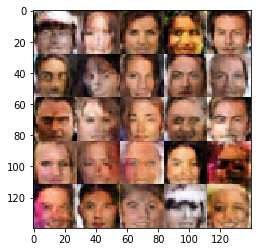

Epoch 1/1, Batch:2720... Discriminator Loss: 1.2507... Generator Loss: 0.8658
Epoch 1/1, Batch:2740... Discriminator Loss: 1.3777... Generator Loss: 0.5738
Epoch 1/1, Batch:2760... Discriminator Loss: 1.6876... Generator Loss: 0.3739
Epoch 1/1, Batch:2780... Discriminator Loss: 1.4849... Generator Loss: 0.6682
Epoch 1/1, Batch:2800... Discriminator Loss: 1.3923... Generator Loss: 0.9817
[None, 28, 28, 3]


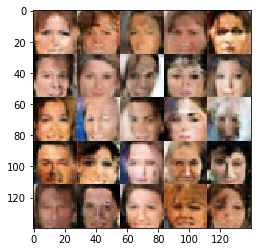

Epoch 1/1, Batch:2820... Discriminator Loss: 1.4469... Generator Loss: 1.2297
Epoch 1/1, Batch:2840... Discriminator Loss: 1.3520... Generator Loss: 0.9504
Epoch 1/1, Batch:2860... Discriminator Loss: 1.4188... Generator Loss: 0.5341
Epoch 1/1, Batch:2880... Discriminator Loss: 0.8482... Generator Loss: 1.2917
Epoch 1/1, Batch:2900... Discriminator Loss: 1.4973... Generator Loss: 0.5129
[None, 28, 28, 3]


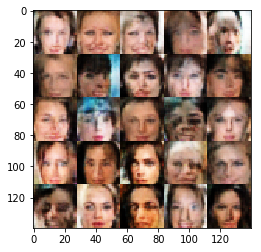

Epoch 1/1, Batch:2920... Discriminator Loss: 1.3575... Generator Loss: 1.1116
Epoch 1/1, Batch:2940... Discriminator Loss: 1.2516... Generator Loss: 0.8326
Epoch 1/1, Batch:2960... Discriminator Loss: 1.1048... Generator Loss: 1.1805
Epoch 1/1, Batch:2980... Discriminator Loss: 1.4395... Generator Loss: 0.4989
Epoch 1/1, Batch:3000... Discriminator Loss: 1.2587... Generator Loss: 1.0815
[None, 28, 28, 3]


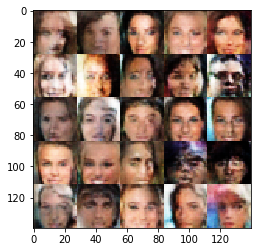

Epoch 1/1, Batch:3020... Discriminator Loss: 1.1364... Generator Loss: 1.1532
Epoch 1/1, Batch:3040... Discriminator Loss: 1.2415... Generator Loss: 0.8809
Epoch 1/1, Batch:3060... Discriminator Loss: 1.2365... Generator Loss: 0.7827
Epoch 1/1, Batch:3080... Discriminator Loss: 1.2195... Generator Loss: 1.2193
Epoch 1/1, Batch:3100... Discriminator Loss: 1.3752... Generator Loss: 0.5520
[None, 28, 28, 3]


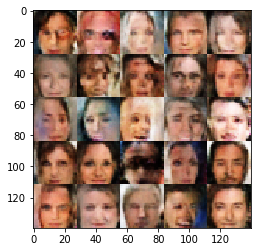

Epoch 1/1, Batch:3120... Discriminator Loss: 1.1253... Generator Loss: 1.1062
Epoch 1/1, Batch:3140... Discriminator Loss: 1.3940... Generator Loss: 0.7597
Epoch 1/1, Batch:3160... Discriminator Loss: 1.3661... Generator Loss: 0.6979


In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.